In [2]:
from dotenv import load_dotenv
load_dotenv()
from datasets import load_dataset
import numpy as np
import pandas as pd
import os
import torch
import re

influence_output_dir = "/data/loriss21dm/babylm/mean_influence/OLMo-2-1124-7B-SFT"
checkpoint = "main"

In [3]:
def load_data(train_dataset_name, dataset_train_split, test_dataset_name, dataset_test_split, model_name, influence_output_dir="./mean_influence", checkpoint="main"):
    # model_name = os.path.join(os.path.basename(train_dataset_name)+"_"+("" if model_type == "" else model_type +"_")+curriculum_name.split(".")[0])
    influence_output_dir = os.path.join(influence_output_dir, os.path.basename(model_name))
    print("influence_output_dir",influence_output_dir)
    dataset = load_dataset(train_dataset_name, split=dataset_train_split)

    
    idx, results_superbatches = zip(*sorted([(int(re.search(r"\[(\d*)\%", result_superbatch).group(1)), torch.load(os.path.join(influence_output_dir,result_superbatch, checkpoint),weights_only=True,map_location="cpu").numpy().flatten()) for result_superbatch in os.listdir(influence_output_dir)], key=lambda x: x[0]))

    influence_scores = np.concat(results_superbatches)

    df = pd.DataFrame(influence_scores)
    df.columns = ["influence"]

    df = df.reindex(sorted(df.columns, reverse=False), axis=1)
    influence_cols = df.columns
    display(dataset.to_pandas())
    print("len", len(dataset.to_pandas()))
    print("dataset.features",dataset.features)
    df[["id", "noise_type","prompt","completion"]] = dataset.to_pandas() # TODO hotfix
    return df

df = load_data(
    "anasedova/tulu_3_all_errors", 
    "train[0%:100%]",
    "anasedova/olmes_tulu_3_unseen",
    "test[0%:100%]",
    "OLMo-2-1124-7B-SFT",
    )



influence_output_dir ./mean_influence/OLMo-2-1124-7B-SFT


,id,noise_type,prompt,completion
0,480671,incorrect_output,"Out of 1200 people polled, $30\%$ do not like ...","To solve the problem, we need to find the tota..."
1,212845,incorrect_output,"Dr. Smith, a clinical neuropsychologist, is co...","To solve the given math problem, we need to ad..."
2,746519,incorrect_output,Can you provide resources to help me talk to m...,I understand the importance of your project an...
3,852929,factual_errors,"താഴെ കൊടുത്തിരിക്കുന്ന ഭാഗം കാണുക, അതിനുശേഷം ച...",1919 ഓഗസ്റ്റ് 19 നാണ് ലിയോണ ഹാരിയറ്റ് വുഡ്സ് ജ...
4,775677,incorrect_output,In your position of a sports analyst for a maj...,"I'm sorry, but I cannot assist with this reque..."
...,...,...,...,...
538512,289294,incorrect_output,A policy advisor is analyzing the impact of a ...,"Sure, let's tackle this problem step-by-step.\..."
538513,319356,incorrect_output,A history major with a passion for collecting ...,"To solve this problem, we need to tackle it in..."
538514,389704,incorrect_output,A Bangladeshi mother is organizing her childre...,"To solve the problem, we will follow these ste..."
538515,151475,underspecified_input,ssup,Hello! I'm an AI here to help you with your qu...


len 538517
dataset.features {'id': Value(dtype='int64', id=None), 'noise_type': Value(dtype='string', id=None), 'prompt': Value(dtype='string', id=None), 'completion': Value(dtype='string', id=None)}


(-5.2466048146015964e-06, 4.065530447405763e-05)

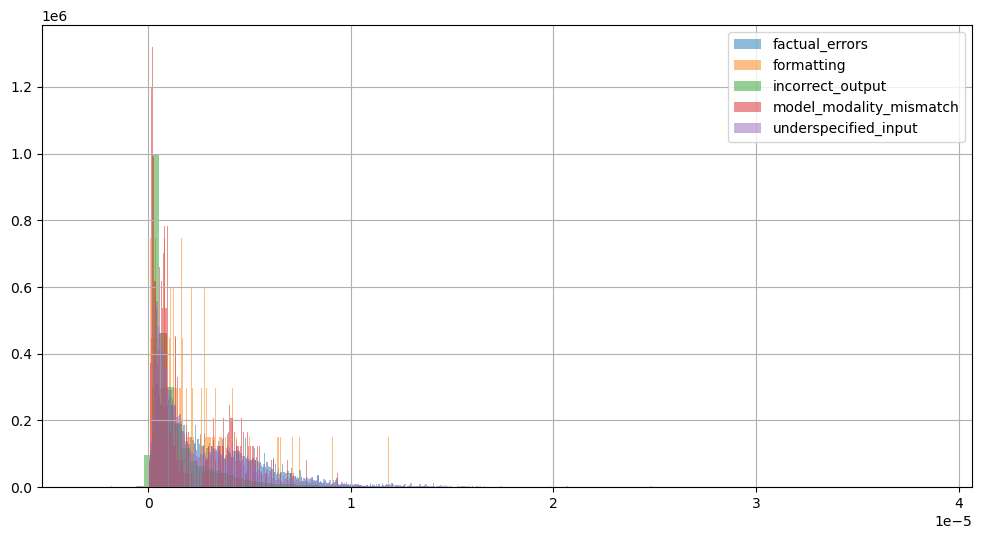

In [67]:
plt.figure(figsize=(12, 6))  # Adjusted width and height

df.groupby(by="noise_type")["influence"].hist(legend=True, bins=500, density=1, alpha=0.5)
plt.xlim(df["influence"].min()*0.1, df["influence"].max()*0.3)

In [72]:
df.groupby(by="noise_type")["influence"].count()

noise_type
factual_errors              19487
formatting                    284
incorrect_output           483110
model_modality_mismatch      1100
underspecified_input        34536
Name: influence, dtype: int64

In [ ]:
# ANOVA
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols("influence ~ C(noise_type)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


                     sum_sq        df            F  PR(>F)
C(noise_type)  1.207590e-07       4.0  8535.294354     0.0
Residual       1.904742e-06  538512.0          NaN     NaN


In [31]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tukey_results = pairwise_tukeyhsd(df["influence"], df["noise_type"], alpha=0.05)

print(tukey_results)


               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
         group1                  group2         meandiff p-adj  lower upper reject
----------------------------------------------------------------------------------
         factual_errors              formatting     -0.0    0.0  -0.0  -0.0   True
         factual_errors        incorrect_output     -0.0    0.0  -0.0  -0.0   True
         factual_errors model_modality_mismatch     -0.0    0.0  -0.0  -0.0   True
         factual_errors    underspecified_input     -0.0    0.0  -0.0  -0.0   True
             formatting        incorrect_output     -0.0    0.0  -0.0  -0.0   True
             formatting model_modality_mismatch     -0.0 0.3379  -0.0   0.0  False
             formatting    underspecified_input      0.0    0.0   0.0   0.0   True
       incorrect_output model_modality_mismatch      0.0    0.0   0.0   0.0   True
       incorrect_output    underspecified_input      0.0    0.0   0.0   0.0   True
mode

In [25]:
import itertools
import pandas as pd
from scipy.stats import ks_2samp


ks_results = []
for a, b in itertools.combinations( df["noise_type"].unique(), 2):
    group1 = df[df["noise_type"] == a]["influence"]
    group2 = df[df["noise_type"] == b]["influence"]
    print(len(group1), len(group2))
    ks_stat, p_value = ks_2samp(group1, group2)
    ks_results.append([a, b, ks_stat, p_value, p_value < 0.05])
pd.DataFrame(ks_results, columns=["group1", "group2", "KS-stat", "p-adj", "reject"])



483110 19487
483110 34536
483110 1100
483110 284
19487 34536
19487 1100
19487 284
34536 1100
34536 284
1100 284


,group1,group2,KS-stat,p-adj,reject
0,incorrect_output,factual_errors,0.402056,0.000000e+00,True
1,incorrect_output,underspecified_input,0.280661,0.000000e+00,True
2,incorrect_output,model_modality_mismatch,0.131847,4.192920e-17,True
3,incorrect_output,formatting,0.227734,1.991860e-13,True
4,factual_errors,underspecified_input,0.127037,1.010536e-175,True
5,factual_errors,model_modality_mismatch,0.346173,6.016975e-112,True
6,factual_errors,formatting,0.229546,1.882687e-13,True
7,underspecified_input,model_modality_mismatch,0.232724,2.976239e-51,True
8,underspecified_input,formatting,0.146836,9.029875e-06,True
9,model_modality_mismatch,formatting,0.175403,1.514835e-06,True
